# Dual-module Bayesian Neural Network

TODO: intro



In [0]:
# Install packages
#!pip install -q --upgrade tensorflow==2.0.0-beta0
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q tfp-nightly
!pip install -q catboost
!pip install -q --pre vaex

In [0]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex

from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.math import random_rademacher

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from catboost import CatBoostRegressor

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.random.set_seed(111)

## Data

TODO: explain, mention more eda in previous post

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Columns to load
dtypes = {'fare_amount':      'float32',
          'pickup_datetime':  'str', 
          'pickup_longitude': 'float32',
          'pickup_latitude':  'float32',
          'dropoff_longitude':'float32',
          'dropoff_latitude': 'float32'}

# Load data
#train = pd.read_csv('train.csv', # TODO
train = pd.read_csv('/content/gdrive/My Drive/DataScience/Data/train.zip', 
                    usecols=dtypes.keys(), 
                    dtype=dtypes,
                    nrows=200000)

# Convert pickup time column to datetime
train['pickup_datetime'] = train['pickup_datetime'].str.slice(0, 16)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], 
                                          utc=True, 
                                          format='%Y-%m-%d %H:%M')

In [0]:
# Drop rows with empty values
train.dropna(inplace=True)

# Extract useful time information
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute)
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear
train['year'] = train['pickup_datetime'].dt.year

# Remove original datetime column
train.drop('pickup_datetime', axis=1, inplace=True)

# Ensure all columns are float32s
train = train.astype('float32')

# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove outliers
train = clip(train, 1, 200, ['fare_amount'])
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

# Make copy with untransformed data
train_orig = train.copy()

# Transform target column
train['fare_amount'] = np.log(np.log10(train['fare_amount']))

# Normalize data
train = (train - train.mean()) / train.std()

# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

TODO: print head and simple plots

## Baseline Models

In [0]:
# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

In [7]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 0.7927840153376261


In [8]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(x_taxi['pickup_longitude'] -
             x_taxi['dropoff_longitude'], 2) + 
    np.power(x_taxi['pickup_latitude'] - 
             x_taxi['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 0.3694203396638234


TODO: let's also see how a gradient-boosted decision tree does.

In [0]:
# MAE using CatBoost
cv_mae(CatBoostRegressor(verbose=False, depth=9), x_taxi, y_taxi)

MAE: 0.30021984335733554


## Vanilla Neural Network

TODO: talk about just prediction w/ nnet w/ MAE

In [0]:
# Run simple keras model to get MAE
D = x_taxi.shape[1]
model = Sequential([
    Dense(512, use_bias=False, input_shape=(D,)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(128, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(64, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(1)
])

In [0]:
# Compile the model using MAE
model.compile(Adam(), loss='mean_absolute_error')

In [11]:
# Stop training when we start to overfit
# Reduce learning rate if not improving
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=10, min_delta=1e-4)
]

# Fit the model
history = model.fit(x_taxi, y_taxi,
                    batch_size=1024,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=callbacks,
                    verbose=2)

W0706 04:15:33.766726 140673704961920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 156656 samples, validate on 39164 samples
Epoch 1/100
156656/156656 - 2s - loss: 0.4790 - val_loss: 0.6710
Epoch 2/100
156656/156656 - 1s - loss: 0.3662 - val_loss: 0.5413
Epoch 3/100
156656/156656 - 1s - loss: 0.3450 - val_loss: 0.3510
Epoch 4/100
156656/156656 - 1s - loss: 0.3329 - val_loss: 0.3059
Epoch 5/100
156656/156656 - 1s - loss: 0.3265 - val_loss: 0.3051
Epoch 6/100
156656/156656 - 1s - loss: 0.3204 - val_loss: 0.2932
Epoch 7/100
156656/156656 - 1s - loss: 0.3190 - val_loss: 0.2929
Epoch 8/100
156656/156656 - 1s - loss: 0.3160 - val_loss: 0.2874
Epoch 9/100
156656/156656 - 1s - loss: 0.3142 - val_loss: 0.2887
Epoch 10/100
156656/156656 - 1s - loss: 0.3124 - val_loss: 0.2877
Epoch 11/100
156656/156656 - 1s - loss: 0.3112 - val_loss: 0.2843
Epoch 12/100
156656/156656 - 1s - loss: 0.3100 - val_loss: 0.2827
Epoch 13/100
156656/156656 - 1s - loss: 0.3078 - val_loss: 0.2844
Epoch 14/100
156656/156656 - 1s - loss: 0.3063 - val_loss: 0.2873
Epoch 15/100
156656/156656 - 1s - 

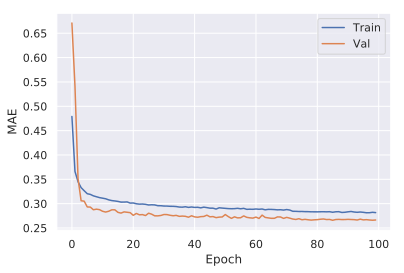

In [12]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

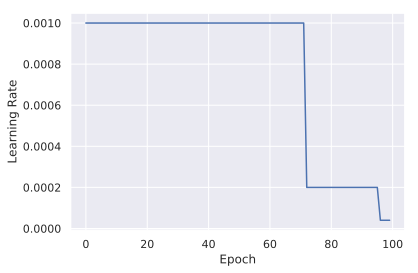

In [13]:
plt.plot(history.history['lr'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

## Testing a simple bayesian neural net

(with no flipout)

This works:



In [14]:
# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=x_taxi.shape[0],
                          p=[0.2, 0.8])
x_train = x_taxi[tr_ind].values
y_train = y_taxi[tr_ind].values
x_val = x_taxi[~tr_ind].values
y_val = y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

# Make a TensorFlow Dataset from training data
batch_size = 1024
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)

W0706 04:17:11.257626 140673704961920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/data/util/random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
class BayesianDenseLayer(tf.keras.Model):
    
    def __init__(self, d_in, d_out, name=None):
        
        # Xavier initializer
        def xavier(shape):
            return tf.random.truncated_normal(
                shape, 
                mean=0.0,
                stddev=np.sqrt(2/sum(shape)))
        
        super(BayesianDenseLayer, self).__init__(name=name)
        
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
        
    
    def call(self, x, sampling=True):
        
        if sampling:
            weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
            bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
            return x @ weight.sample() + bias.sample()
            
        else:
            return x @ self.w_loc + self.b_loc
    
    
    @property
    def losses(self):
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))

In [0]:
class BayesianDenseNetwork(tf.keras.Model):
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseNetwork, self).__init__(name=name)
        
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            self.acts += [tf.nn.relu]
            
        self.acts[-1] = lambda x: x
        
    
    def call(self, x, sampling=True):
        
        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        return x
    
    
    @property
    def losses(self):
        return tf.reduce_sum([s.losses for s in self.steps])

In [0]:
model = BayesianDenseNetwork([8, 256, 128, 64, 1])

In [18]:

optimizer = tf.keras.optimizers.Adam(lr=1e-3)

N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        preds = model(x_data)
        ll = tf.reduce_mean(tfd.Normal(preds, 1).log_prob(y_data))
        kl_loss = model.losses
        elbo_loss = kl_loss/N - ll
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
# Fit the model
EPOCHS = 50
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        preds = model(x_data, sampling=False)
        mae = mean_absolute_error(preds, y_data)
        print('Epoch {}  \tMAE {}'.format(epoch, mae))

Epoch 0  	MAE 0.34711214900016785
Epoch 1  	MAE 0.304743230342865
Epoch 2  	MAE 0.2952728867530823
Epoch 3  	MAE 0.2911926507949829
Epoch 4  	MAE 0.28870689868927
Epoch 5  	MAE 0.2883450388908386
Epoch 6  	MAE 0.2870854437351227
Epoch 7  	MAE 0.28532689809799194
Epoch 8  	MAE 0.28670617938041687
Epoch 9  	MAE 0.2907015383243561
Epoch 10  	MAE 0.2834812104701996
Epoch 11  	MAE 0.2921922206878662
Epoch 12  	MAE 0.2801137864589691
Epoch 13  	MAE 0.28685876727104187
Epoch 14  	MAE 0.2955887019634247
Epoch 15  	MAE 0.2826129198074341
Epoch 16  	MAE 0.2805829346179962
Epoch 17  	MAE 0.2797192633152008
Epoch 18  	MAE 0.2797364592552185
Epoch 19  	MAE 0.28309860825538635
Epoch 20  	MAE 0.2833879888057709
Epoch 21  	MAE 0.2846357822418213
Epoch 22  	MAE 0.2842925190925598
Epoch 23  	MAE 0.27745774388313293
Epoch 24  	MAE 0.2787505090236664
Epoch 25  	MAE 0.27882081270217896
Epoch 26  	MAE 0.27809590101242065
Epoch 27  	MAE 0.28144755959510803
Epoch 28  	MAE 0.2866879999637604
Epoch 29  	MAE 0.2

## Bayesian Neural Network

TODO: using TF2.0 w/ eager execution and tf.Module

TODO: talk about how you were gonna use TFP but it doesn't fully support TF2.0 eager execution yet!  ie the kl loss was getting reset each batch

TODO: diagram

In [0]:
""" DOESN'T SEEM TO BE WORKING """


class DenseBayesian(tf.keras.Model):
    """Fully-connected Bayesian neural network layer which supports
    both sampling and inference w/ MAP parameter estimates.
    
    Uses normally-distributed variational posteriors, and
    normally-distributed priors with mean=0 and std=1.
    
    Parameters
    ----------
    d_in : int
        Number of input dimensions
    d_out : int
        Number of output dimensions ("units")
    bias : bool
        Whether to include a bias term
    name : None or str
        Name for the layer
    """
    
    
    def __init__(self, d_in, d_out=1, name=None):
        
        # Xavier initializer
        def xavier(shape):
            return tf.random.truncated_normal(
                shape, 
                mean=0.0,
                stddev=np.sqrt(2/sum(shape)))
        
        # Initialize
        super(DenseBayesian, self).__init__(name=name)
        self.d_in = d_in
        self.d_out = d_out
                
        # Variables of the variational posterior distributions
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([d_out])-6.0, name='b_std')
            
    
    def call(self, x, sampling=True):
        """Pass data through the layer
        
        Parameters
        ----------
        x : tf.Tensor
            Input data
        sampling : bool
            Whether to sample parameter values from their variational
            distributions using Flipout (if True, the default), or
            just use the Maximum a Posteriori parameter value
            estimates (if False).
            
        Returns
        -------
        preds : tf.Tensor
            Output of this layer, the predictions
        """
        
        # Convert x to matrix if 1-dimensional
        if len(x.shape) < 2:
            x = tf.expand_dims(x, 1)
        
        # Use Flipout-estimated samples from parameters' var dists
        if sampling:
                        
            # Transform std parameters
            w_std = tf.nn.softplus(self.w_std)
            b_std = tf.nn.softplus(self.b_std)
            
            # Compute effect of weight samples
            s = random_rademacher(tf.shape(x))
            r = random_rademacher([x.shape[0], self.d_out])
            w_samples = w_std*tf.random.normal([self.d_in, self.d_out])
            w_perturbations = r*tf.matmul(x*s, w_samples)
            w_outputs = tf.matmul(x, self.w_loc) + w_perturbations
            
            # Compute effect of bias samples
            r = random_rademacher([x.shape[0], self.d_out])
            b_samples = b_std*tf.random.normal([self.d_out])
            b_outputs = self.b_loc + r*b_samples
            
            return w_outputs + b_outputs
            
        # Use MAP estimates of parameters' variational distributions
        else:
            return tf.matmul(x, self.w_loc) + self.b_loc
                
    
    @property
    def losses(self):
        """The sum of the KL divergences between the priors and
        posteriors, assuming normal priors w/ mean=0 and std=1
        """
        
        # Transform std parameters
        w_std = tf.nn.softplus(self.w_std)
        b_std = tf.nn.softplus(self.b_std)

        # Compute the divergences
        w_loss = 0.5*tf.reduce_sum(tf.square(self.w_loc) + 
                                   tf.square(w_std) -
                                   2*tf.math.log(w_std) - 1)
        b_loss = 0.5*tf.reduce_sum(tf.square(self.b_loc) + 
                                   tf.square(b_std) -
                                   2*tf.math.log(b_std) - 1)
        return w_loss + b_loss

TODO: then need to make a model which takes those predictions and computes likelihood of the target: use a net w/ 2 heads, one for mean and 1 for std

TODO: diagram

In [0]:
class BayesianDensityNetwork(tf.keras.Model):
    """Multilayer fully-connected Bayesian neural network, which
    has two heads to predict both the mean and the standard deviation.
    
    Parameters
    ----------
    input_dims : int
        Number of input dimensions
    units : list of int
        Number of output dimensions for each layer.
    name : None or str
        Name for the layer
    """
    
    
    def __init__(self, input_dims, units, head_units, name=None):
        
        # Initialize
        super(BayesianDensityNetwork, self).__init__(name=name)
        
        # Create layers
        units = [input_dims] + units
        self.steps = []
        for i in range(len(units)-1):
            self.steps += [DenseBayesian(units[i], units[i+1])]

        # Create activation functions
        self.acts = [tf.nn.relu for i in range(len(units))]
        
        # Create layers for heads
        head_units = [units[-1]] + head_units
        self.head1_steps = []
        self.head2_steps = []
        for i in range(len(units)-1):
            self.head1_steps += [DenseBayesian(head_units[i], head_units[i+1])]
            self.head2_steps += [DenseBayesian(head_units[i], head_units[i+1])]
        self.head1_steps += [DenseBayesian(head_units[-1], 1)]
        self.head2_steps += [DenseBayesian(head_units[-1], 1)]
        
        # Create activation functions for heads
        self.head_acts = [tf.nn.relu for i in range(len(head_units)-1)]
        self.head_acts += [lambda x: x] #last layer has no activation

    
    def call(self, x, sampling=True):
        """Pass data through the model
        
        Parameters
        ----------
        x : tf.Tensor
            Input data
        sampling : bool
            Whether to sample parameter values from their variational
            distributions using Flipout (if True, the default), or
            just use the Maximum a Posteriori parameter value
            estimates (if False).
            
        Returns
        -------
        preds : tf.Tensor
            Output of this model, the predictions
        """
        
        # Pass data through core network
        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        # Pass data through heads
        out1 = x
        out2 = x
        for i in range(len(self.steps)):
            out1 = self.head1_steps[i](out1, sampling=sampling)
            out2 = self.head2_steps[i](out2, sampling=sampling)
            out1 = self.head_acts[i](out1)
            out2 = self.head_acts[i](out2)

        return tf.concat([out1, out2], 1)
    
    
    def _normal_log_likelihood(self, y, means, stds):
        """Compute the log likelihood of y given a normal distribution
        with some mean and standard deviation
        """
        return (-0.5*tf.math.log(2*np.pi) - tf.math.log(stds) -
                0.5*tf.square(y-means)/tf.square(stds))
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        preds = self(x)
        return self._normal_log_likelihood(y, preds[:,0],
                                           tf.nn.softplus(preds[:,1]))
        
        
    @property
    def losses(self):
        """The sum of the KL divergences between the priors and
        posteriors, assuming normal priors w/ mean=0 and std=1,
        for all layers.
        """
        return sum([l.losses for l in self.steps])

TODO: make a TF dataset from the data:

In [0]:
# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=x_taxi.shape[0],
                          p=[0.2, 0.8])
x_train = x_taxi[tr_ind].values
y_train = y_taxi[tr_ind].values
x_val = x_taxi[~tr_ind].values
y_val = y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

# Make a TensorFlow Dataset from training data
batch_size = 1024
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)

TODO: now can instantiate and fit the model

In [0]:
# Instantiate the model
model = BayesianDensityNetwork(8, [128, 64], [32, 16])

In [0]:
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [0]:
N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model.log_likelihood(x_data, y_data)
        kl_loss = model.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

TODO: K there's a bug somewhere, the gradients aren't being connected...

In [78]:
# Fit the model
EPOCHS = 3
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        preds = model(x_data, sampling=False)
        y_pred = preds[:, 0]
        mae = mean_absolute_error(y_pred, y_data)
        print('Epoch {}  \tMAE {}'.format(epoch, mae))

W0706 04:13:06.149334 139768724141952 optimizer_v2.py:982] Gradients does not exist for variables ['w_loc:0', 'w_std:0', 'b_loc:0', 'b_std:0', 'w_loc:0', 'w_std:0', 'b_loc:0', 'b_std:0'] when minimizing the loss.
W0706 04:13:07.401564 139768724141952 optimizer_v2.py:982] Gradients does not exist for variables ['w_loc:0', 'w_std:0', 'b_loc:0', 'b_std:0', 'w_loc:0', 'w_std:0', 'b_loc:0', 'b_std:0'] when minimizing the loss.
W0706 04:13:09.786331 139768724141952 optimizer_v2.py:982] Gradients does not exist for variables ['w_loc:0', 'w_std:0', 'b_loc:0', 'b_std:0', 'w_loc:0', 'w_std:0', 'b_loc:0', 'b_std:0'] when minimizing the loss.


Epoch 0  	MAE 0.7937636971473694
Epoch 1  	MAE 0.7937636971473694
Epoch 2  	MAE 0.7937636971473694


TODO: plot MAE, ELBO over training

## Model E

TODO: look at predictive distributions

TODO: look at residuals (using sampling=False)

TODO: look at coverage of the 95% interval

TODO: look at coverage of the 95% interval over some variable, ie time and space like below:

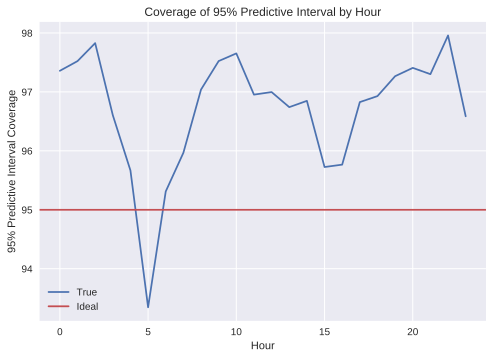

In [0]:
# Plot coverage as a fn of time of day
min_of_day = train_orig.loc[~tr_ind,'min_of_day'].values
covs = np.zeros(24)
for iT in range(0,24):
  ix = ((min_of_day>=(iT*60)) &
        (min_of_day<((iT+1)*60)))
  covs[iT] = coverage(prediction_dists[:,ix,0], y_val[ix])
plt.plot(covs, label='True')
plt.axhline(95.0, label='Ideal', color=colors[2])
plt.xlabel('Hour')
plt.ylabel('95% Predictive Interval Coverage')
plt.title('Coverage of 95% Predictive Interval by Hour')
plt.legend()
plt.show()

TODO: and we can also look at the coverage across pickup location

/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):


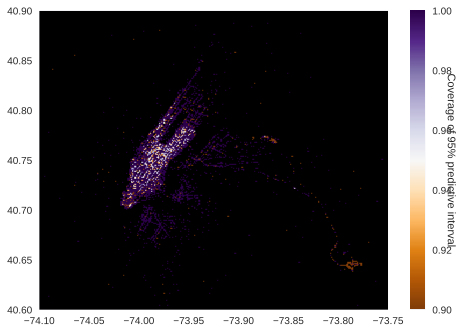

In [0]:
# Create vaex df with predictive intervals
cov_by_loc = pd.DataFrame()
cov_by_loc['x'] = train_orig.loc[~tr_ind,'pickup_longitude']
cov_by_loc['y'] = train_orig.loc[~tr_ind,'pickup_latitude']
cov_by_loc['covered'] = covered(prediction_dists[:,:,0], y_val)
vdf = vaex.from_pandas(cov_by_loc)

# Compute coverage of the predictive interval
lims = [[-74.1, -73.75],[40.6, 40.9]]
cov = vdf.mean(vdf.covered, limits=lims, shape=300,
               binby=[vdf.x,
                      vdf.y])

# Plot coverage of the predictive interval
cmap = matplotlib.cm.PuOr
cmap.set_bad('black', 1.)
plt.imshow(cov.T, origin='lower',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)

TODO: compare net which doesn't predict std dev to one which does?